Let's finally examine how an AdaFNN does. We extensively use the `AdaFNN_research` framework, again.

## Imports

In [1]:
from pathlib import Path
import statistics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import torch
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from IPython.display import Image, display, Math

from tecatorfda.data import load_tecator_fat
from tecatorfda.pca_models import CustomPCA
import adafnnresearch as afr

## Load the data

In [2]:
# Define the data directory to save to.
project_root = Path.cwd().resolve().parent.parent
output_directory = project_root / "artifacts" / "original_data" / "10_adafnn"

# Define the data directory to read from.
data_location_directory = project_root / "data" / "original"
artifacts_location_directory = project_root / "artifacts" / "original_data"

# Load the data.
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat(
    location=data_location_directory
)

# Numpy arrays.
X = tecator_df.to_numpy()
y = fat_df.to_numpy().ravel()
t = np.array(wavelength_grid)
t = (t - t.min()) / (t.max() - t.min())

# Pandas DataFrames.
X_df = tecator_df
y_df = fat_df
t_df = pd.DataFrame(wavelength_grid).T

## Create results directories

In [3]:
output_directory_models = output_directory / "models"
output_directory_scores = output_directory / "scores"

output_directory_models.mkdir(parents=True, exist_ok=True)
output_directory_scores.mkdir(parents=True, exist_ok=True)

## Examinations

Define batch and split sizes.

In [4]:
batch_size = 32
split_custom = (0.64, 0.16, 0.20)

Define units.

In [5]:
t_units = "nm"
X_units = "Absorbance"
y_units = "%"

Create a DataLoader.

In [6]:
dataloader = afr.preprocessing.DataLoader(X_df,
                                          y_df,
                                          t_df,
                                          seed=0,
                                          split_proportions=split_custom,
                                          batch_size=batch_size,
                                          standardize_X=False,
                                          standardize_Y=False)

Plot the first 5 training functionals $X(t)$, along with their corresponding $y$-scores.

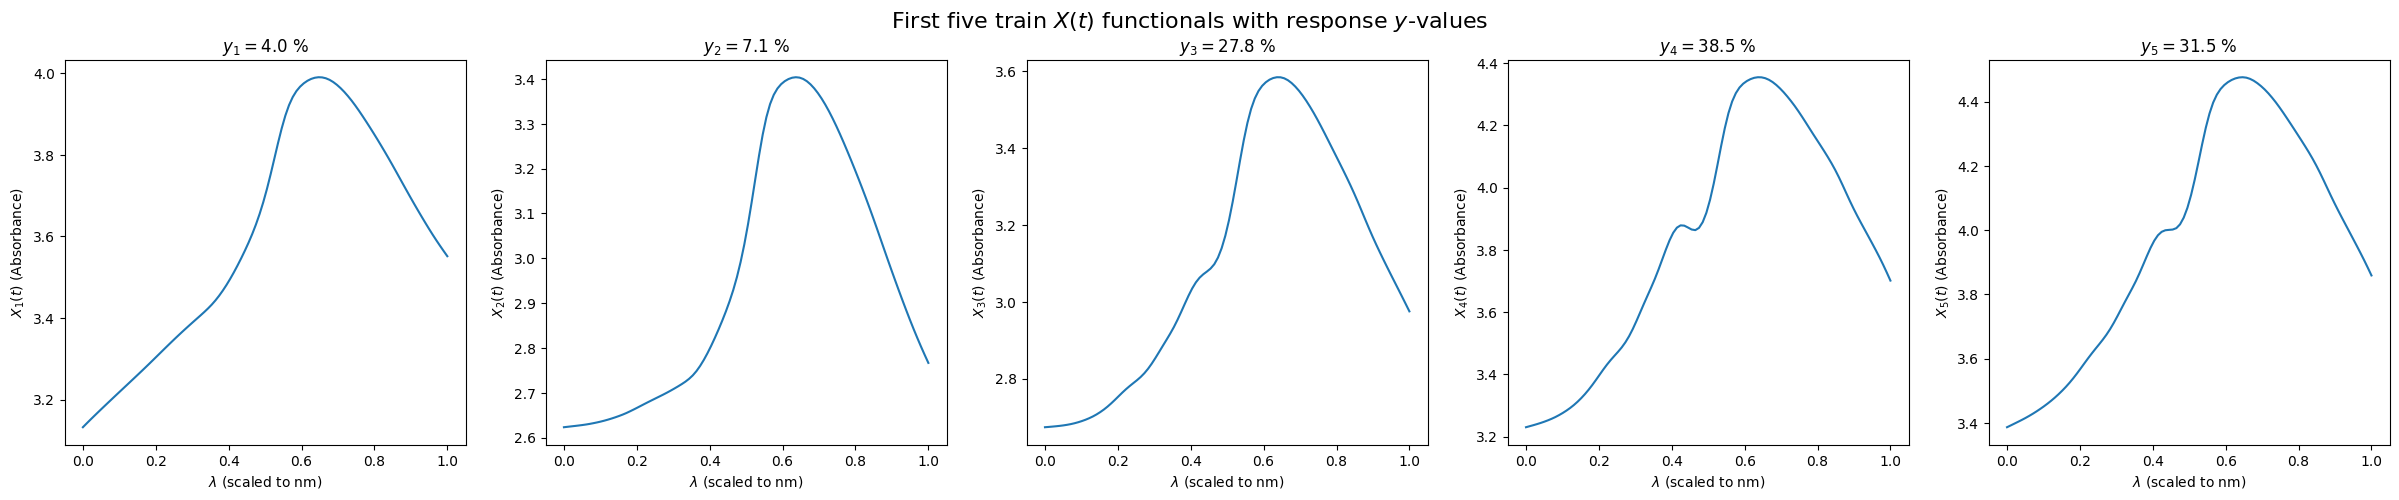

In [7]:
current_batch_gen = dataloader.get_train_batch()
current_batch_X, current_batch_Y = next(current_batch_gen)

fig, ax = plt.subplots(1, 5, figsize=(30, 5))
fig.suptitle("First five train $X(t)$ functionals with response $y$-values", fontsize=16)

for i in range(5):
    ax[i].plot(t, current_batch_X[i])
    ax[i].set_xlabel(fr"$\lambda$ (scaled to {t_units})")
    ax[i].set_ylabel(f"$X_{i+1}(t)$ ({X_units})")
    ax[i].set_title(f"$y_{i+1} = {round(current_batch_Y[i,0].item(), 4)}$ {y_units}")

plt.show()

## AdaFNN tests on split

### 1 basis node

In [10]:
n_base = 1
basis_node_hidden_layers = (20, 20)
subsequent_hidden_layers = (20, 20)
grid = t
r1_penalty = 0.
r2_penalty = 0.
activation = torch.nn.functional.relu
dropout = 0.0
device = "cpu"
optimizer_name = "adam"
learning_rate = 0.001
loss_fn = "MSE"
seed = 0
layer_norm = True

num_epochs = None
patience = 500
to_convergence = True
verbose = True

In [11]:
# Define an AdaFNN.
adaFNN_1_bn = afr.adafnn.AdaFNN(n_base=n_base,
                                basis_node_hidden_layers=basis_node_hidden_layers,
                                subsequent_hidden_layers=subsequent_hidden_layers,
                                grid=grid,
                                r1_penalty=r1_penalty,
                                r2_penalty=r2_penalty,
                                activation=activation,
                                dropout=dropout,
                                device=device,
                                optimizer_name=optimizer_name,
                                learning_rate=learning_rate,
                                loss_fn=loss_fn,
                                seed=seed,
                                layer_norm=layer_norm)
adaFNN_1_bn.float()
# Fit.
adaFNN_1_bn.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  patience=patience,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
adaFNN_1_bn_train_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="train").numpy()
adaFNN_1_bn_valid_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="valid").numpy()
adaFNN_1_bn_test_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 509.4640981855183. Validation loss: 543.3633422851562.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 498.62998906713335. Validation loss: 531.4339826311384.
Epoch 3 is best so far. Saved!
Epoch 3. Train loss: 487.4272318373631. Validation loss: 519.3058122907365.
Epoch 4 is best so far. Saved!
Epoch 4. Train loss: 476.11587925374937. Validation loss: 507.22132917131694.
Epoch 5 is best so far. Saved!
Epoch 5. Train loss: 464.4357832191634. Validation loss: 495.5775931222098.
Epoch 6 is best so far. Saved!
Epoch 6. Train loss: 454.9414784229585. Validation loss: 488.7627371651785.
Epoch 7 is best so far. Saved!
Epoch 7. Train loss: 448.1595946820113. Validation loss: 479.54412667410713.
Epoch 8 is best so far. Saved!
Epoch 8. Train loss: 440.02620212527086. Validation loss: 471.8936104910714.
Epoch 9 is best so far. Saved!
Epoch 9. Train loss: 432.76000419672386. Validation loss: 463.9018607003348.
Epoch 10 

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 361
Train R^2: 0.2398
Train MSE: 124.17162934175056
Valid R^2: 0.1746
Valid MSE: 131.608142404016
Test R^2: 0.1363
Test MSE: 135.30068610409916


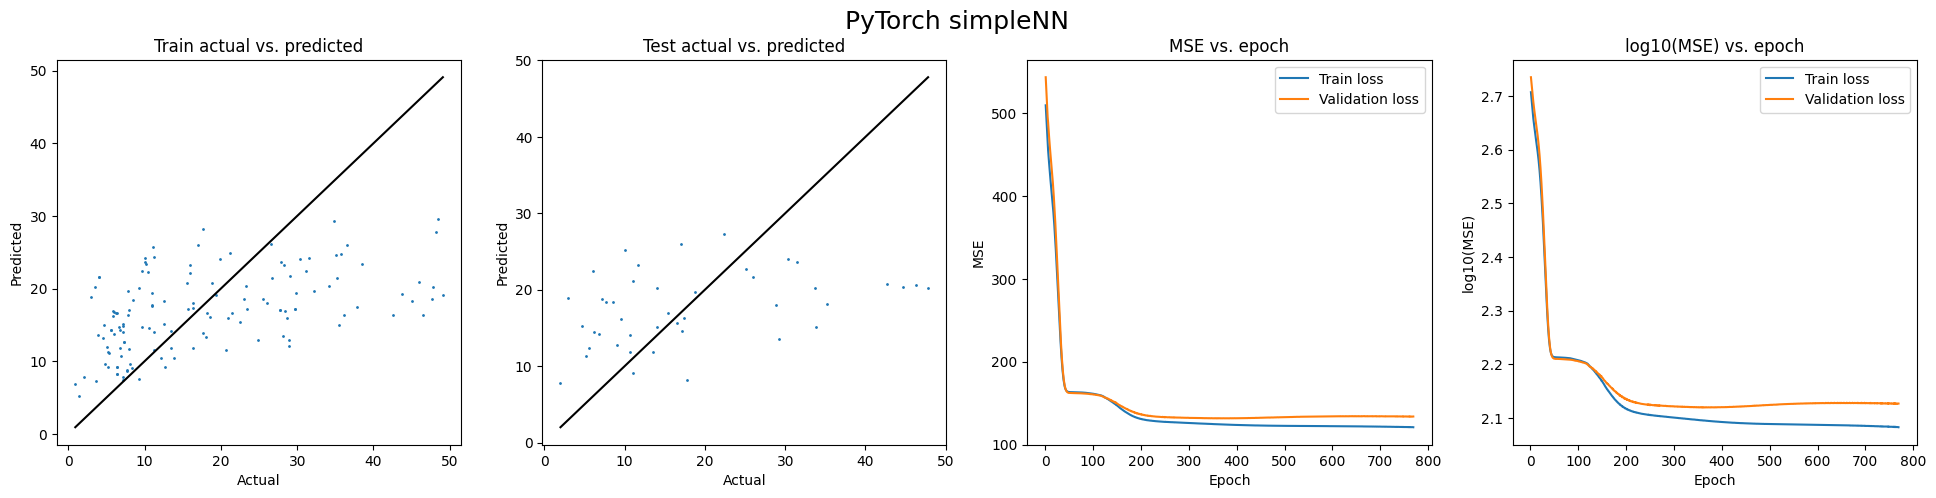

In [12]:
adaFNN_1_bn.useful_plots(dataloader)

### 2 basis nodes

In [13]:
n_base = 2
basis_node_hidden_layers = (20, 20)
subsequent_hidden_layers = (20, 20)
grid = t
r1_penalty = 0.
r2_penalty = 0.
activation = torch.nn.functional.relu
dropout = 0.0
device = "cpu"
optimizer_name = "adam"
learning_rate = 0.001
loss_fn = "MSE"
seed = 0
layer_norm = True

num_epochs = None
patience = 500
to_convergence = True
verbose = True

In [14]:
# Define an AdaFNN.
adaFNN_1_bn = afr.adafnn.AdaFNN(n_base=n_base,
                                basis_node_hidden_layers=basis_node_hidden_layers,
                                subsequent_hidden_layers=subsequent_hidden_layers,
                                grid=grid,
                                r1_penalty=r1_penalty,
                                r2_penalty=r2_penalty,
                                activation=activation,
                                dropout=dropout,
                                device=device,
                                optimizer_name=optimizer_name,
                                learning_rate=learning_rate,
                                loss_fn=loss_fn,
                                seed=seed,
                                layer_norm=layer_norm)
adaFNN_1_bn.float()
# Fit.
adaFNN_1_bn.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  patience=patience,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
adaFNN_1_bn_train_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="train").numpy()
adaFNN_1_bn_valid_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="valid").numpy()
adaFNN_1_bn_test_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 439.229357865605. Validation loss: 469.52130824497766.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 429.5581533612996. Validation loss: 457.1965977260045.
Epoch 3 is best so far. Saved!
Epoch 3. Train loss: 417.89163586693087. Validation loss: 444.8031188964843.
Epoch 4 is best so far. Saved!
Epoch 4. Train loss: 407.80346902443546. Validation loss: 438.11479928152903.
Epoch 5 is best so far. Saved!
Epoch 5. Train loss: 400.6260048525177. Validation loss: 427.7491952078683.
Epoch 6 is best so far. Saved!
Epoch 6. Train loss: 391.5634902619967. Validation loss: 419.11270228794643.
Epoch 7 is best so far. Saved!
Epoch 7. Train loss: 383.6884126315152. Validation loss: 410.091100202288.
Epoch 8 is best so far. Saved!
Epoch 8. Train loss: 375.7653420998232. Validation loss: 402.8253252301897.
Epoch 9 is best so far. Saved!
Epoch 9. Train loss: 368.7340136896955. Validation loss: 395.08076171874995.
Epoch 10 is

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 668
Train R^2: 0.2427
Train MSE: 123.70842397767102
Valid R^2: 0.1599
Valid MSE: 133.9478696809783
Test R^2: 0.1219
Test MSE: 137.55354960189797


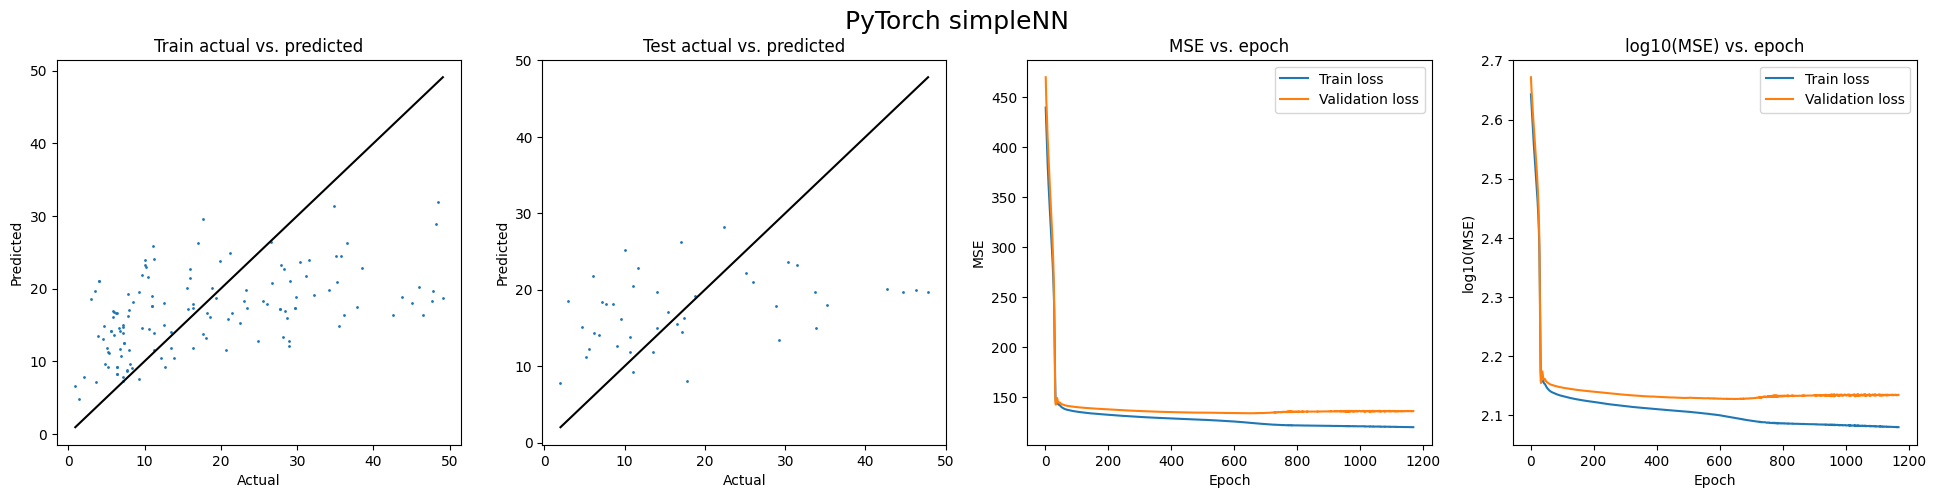

In [15]:
adaFNN_1_bn.useful_plots(dataloader)

### 3 basis nodes

In [27]:
n_base = 3
basis_node_hidden_layers = (20, 20)
subsequent_hidden_layers = (20, 20)
grid = t
r1_penalty = 0.
r2_penalty = 0.
activation = torch.nn.functional.relu
dropout = 0.0
device = "cpu"
optimizer_name = "adam"
learning_rate = 0.001
loss_fn = "MSE"
seed = 0
layer_norm = True

num_epochs = None
patience = 500
to_convergence = True
verbose = True

In [28]:
# Define an AdaFNN.
adaFNN_1_bn = afr.adafnn.AdaFNN(n_base=n_base,
                                basis_node_hidden_layers=basis_node_hidden_layers,
                                subsequent_hidden_layers=subsequent_hidden_layers,
                                grid=grid,
                                r1_penalty=r1_penalty,
                                r2_penalty=r2_penalty,
                                activation=activation,
                                dropout=dropout,
                                device=device,
                                optimizer_name=optimizer_name,
                                learning_rate=learning_rate,
                                loss_fn=loss_fn,
                                seed=seed,
                                layer_norm=layer_norm)
adaFNN_1_bn.float()
# Fit.
adaFNN_1_bn.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  patience=patience,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
adaFNN_1_bn_train_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="train").numpy()
adaFNN_1_bn_valid_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="valid").numpy()
adaFNN_1_bn_test_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 488.9214359478359. Validation loss: 519.6418544224331.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 475.69088856495205. Validation loss: 505.89936523437495.
Epoch 3 is best so far. Saved!
Epoch 3. Train loss: 463.8213772738937. Validation loss: 496.8413783482143.
Epoch 4 is best so far. Saved!
Epoch 4. Train loss: 456.65748406848763. Validation loss: 491.09012102399555.
Epoch 5 is best so far. Saved!
Epoch 5. Train loss: 451.25405527379394. Validation loss: 485.3966605050223.
Epoch 6 is best so far. Saved!
Epoch 6. Train loss: 445.8746110679459. Validation loss: 479.70217808314726.
Epoch 7 is best so far. Saved!
Epoch 7. Train loss: 440.35716615106065. Validation loss: 473.55868094308033.
Epoch 8 is best so far. Saved!
Epoch 8. Train loss: 434.31275973354815. Validation loss: 466.47413155691964.
Epoch 9 is best so far. Saved!
Epoch 9. Train loss: 427.10870662048785. Validation loss: 457.58827427455356.
Epo

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 523
Train R^2: 0.1942
Train MSE: 131.63157898180032
Valid R^2: 0.139
Valid MSE: 137.27966984151462
Test R^2: 0.0971
Test MSE: 141.43342199507018


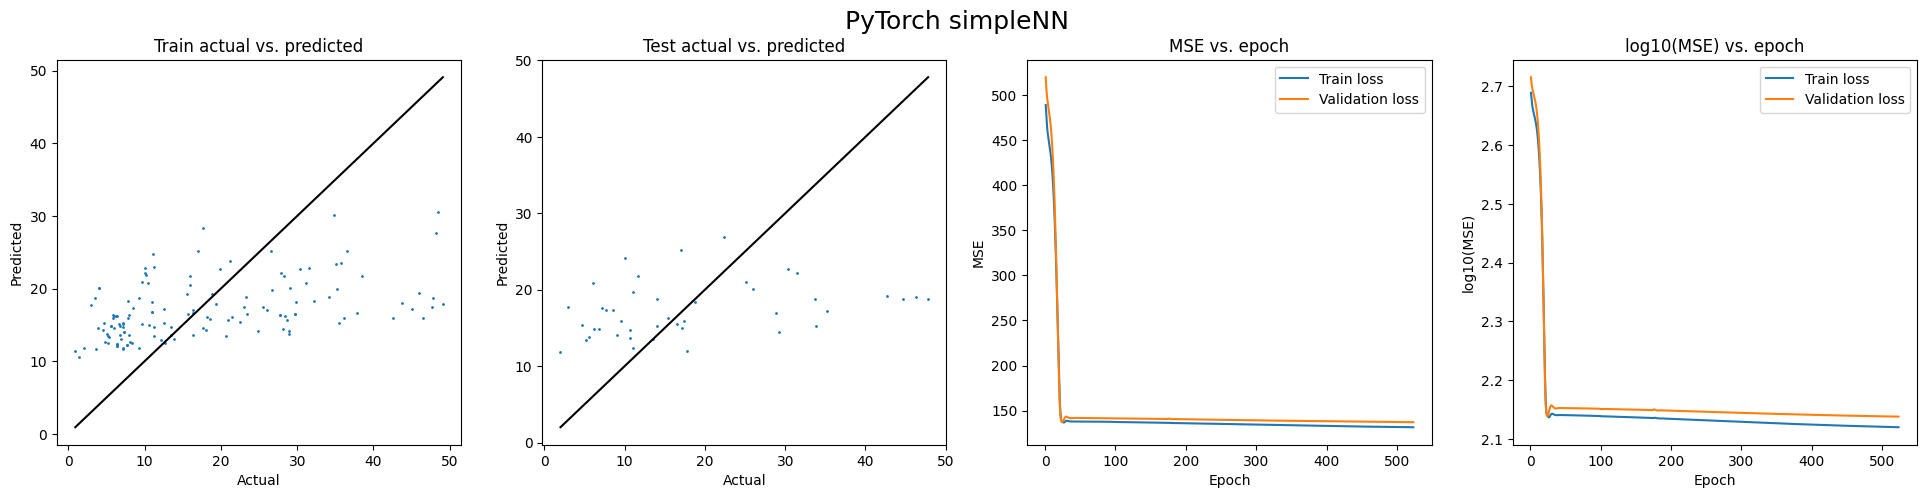

In [29]:
adaFNN_1_bn.useful_plots(dataloader)

### A first configuration that does a little better

In [34]:
n_base = 2
basis_node_hidden_layers = (50, 50)
subsequent_hidden_layers = (500, 500)
grid = t #  / (t.max() - t.min())
r1_penalty = 0.
r2_penalty = 0.
activation = torch.nn.functional.relu
dropout = 0.0
device = "cpu"
optimizer_name = "adam"
learning_rate = 0.001
loss_fn = "MSE"
seed = 0
layer_norm = True

num_epochs = None
patience = 500
to_convergence = True
verbose = True

In [35]:
# Define an AdaFNN.
adaFNN_1_bn = afr.adafnn.AdaFNN(n_base=n_base,
                                basis_node_hidden_layers=basis_node_hidden_layers,
                                subsequent_hidden_layers=subsequent_hidden_layers,
                                grid=grid,
                                r1_penalty=r1_penalty,
                                r2_penalty=r2_penalty,
                                activation=activation,
                                dropout=dropout,
                                device=device,
                                optimizer_name=optimizer_name,
                                learning_rate=learning_rate,
                                loss_fn=loss_fn,
                                seed=seed,
                                layer_norm=layer_norm)
adaFNN_1_bn.float()
# Fit.
adaFNN_1_bn.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  patience=patience,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
adaFNN_1_bn_train_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="train").numpy()
adaFNN_1_bn_valid_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="valid").numpy()
adaFNN_1_bn_test_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 376.25476040805347. Validation loss: 174.76773463657926.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 171.63006770001712. Validation loss: 150.94600655691966.
Epoch 3. Train loss: 145.30574091333543. Validation loss: 159.4893382481166.
Epoch 4. Train loss: 155.8114333326799. Validation loss: 167.66710030691965.
Epoch 5 is best so far. Saved!
Epoch 5. Train loss: 155.93653268187583. Validation loss: 146.85377720424108.
Epoch 6 is best so far. Saved!
Epoch 6. Train loss: 147.16642070686729. Validation loss: 142.58073011125836.
Epoch 7. Train loss: 142.242376786949. Validation loss: 148.104252406529.
Epoch 8. Train loss: 144.28908928641437. Validation loss: 151.4951649257115.
Epoch 9. Train loss: 145.15596565190893. Validation loss: 144.13328683035712.
Epoch 10 is best so far. Saved!
Epoch 10. Train loss: 141.29319701925684. Validation loss: 142.13394622802736.
Epoch 11. Train loss: 138.97722274891652. Valida

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 5749
Train R^2: 0.7391
Train MSE: 42.62164171274482
Valid R^2: 0.7483
Valid MSE: 40.12471943230645
Test R^2: 0.3123
Test MSE: 107.72126400679328


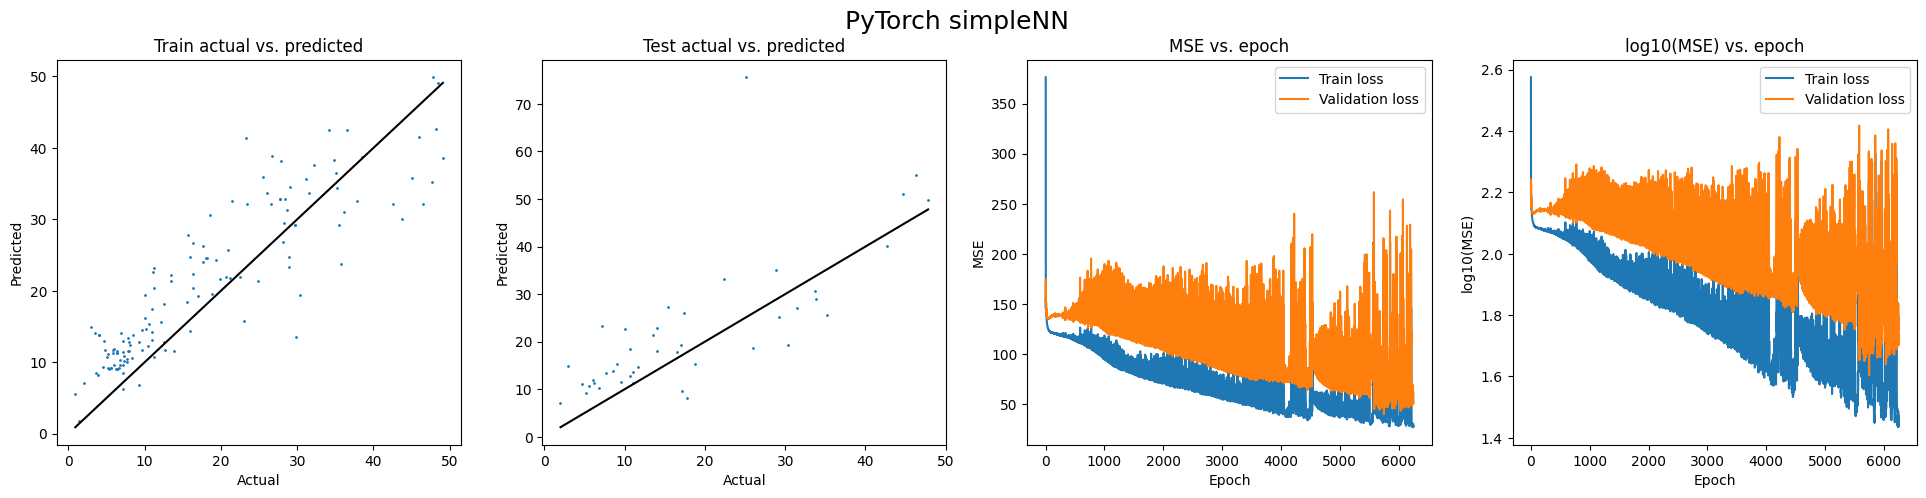

In [36]:
adaFNN_1_bn.useful_plots(dataloader)

#### Examine basis functions

Inner products between all pairs of normalized basis functions:
AdaFNN 0:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

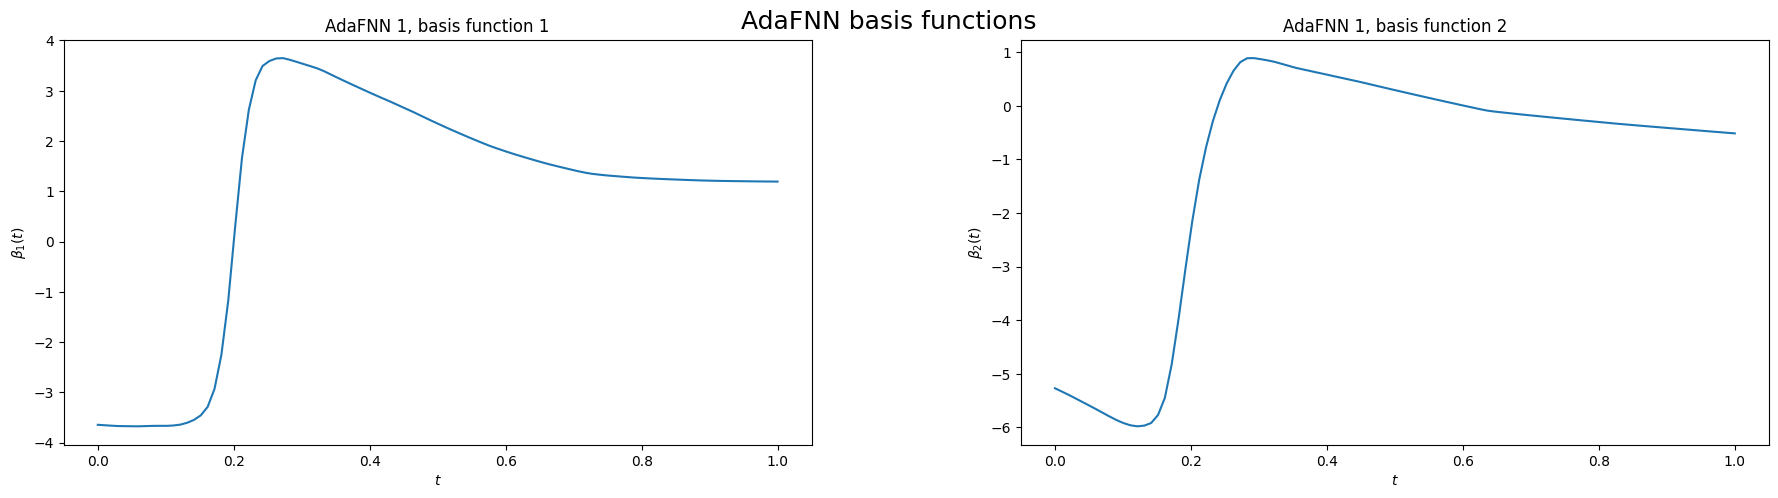

In [37]:
adafnns = [adaFNN_1_bn]

def _normalized_inner_product(f, g, h):
    f_norm = afr.math._inner_product(f, f, h)
    g_norm = afr.math._inner_product(g, g, h)

    return round(afr.math._inner_product(f / torch.sqrt(f_norm), g / torch.sqrt(g_norm), h).item(), 4)

# Plot train and test actual vs. predicted.
fig, ax = plt.subplots(1, adaFNN_1_bn.n_base, figsize=(22, 5))
# ax = ax.flatten()
fig.suptitle("AdaFNN basis functions", fontsize=18, y=0.98)

for i in range(len(adafnns)):
    for j in range(adafnns[0].n_base):
        k = len(adafnns)*i + j
        ax[k].plot(t, adafnns[i].bases[j].flatten())
        ax[k].set_xlabel("$t$")
        ax[k].set_ylabel(f"$\\beta_{j+1}(t)$")
        ax[k].set_title(f"AdaFNN {i+1}, basis function {j+1}")

fig.subplots_adjust(top=0.92, hspace=0.32, wspace=0.28)

print("Inner products between all pairs of normalized basis functions:")
for i in range(len(adafnns)):
    adafnn = adafnns[i]
    print(f"AdaFNN {i}:")
    for j in range(adafnn.n_base):
        for k in range(j,adafnn.n_base):
            display(Math(r"\left< \beta_{}, \beta_{} \right> = {}".format(j, k, _normalized_inner_product(adafnn.bases[j], adafnn.bases[k], adafnn.h))))

plt.show()

### Same hyperparameters but with orthogonalization (doesn't work...)

In [64]:
n_base = 1
basis_node_hidden_layers = (50, 50)
subsequent_hidden_layers = (500, 500)
grid = t #  / (t.max() - t.min())
r1_penalty = 0.
r2_penalty = 0.
activation = torch.nn.functional.relu
dropout = 0.0
device = "cpu"
optimizer_name = "adam"
learning_rate = 0.001
loss_fn = "MSE"
seed = 1
layer_norm = True

num_epochs = None
patience = 500
to_convergence = True
verbose = True

In [65]:
# Define an AdaFNN.
adaFNN_1_bn = afr.adafnn.AdaFNN(n_base=n_base,
                                basis_node_hidden_layers=basis_node_hidden_layers,
                                subsequent_hidden_layers=subsequent_hidden_layers,
                                grid=grid,
                                r1_penalty=r1_penalty,
                                r2_penalty=r2_penalty,
                                activation=activation,
                                dropout=dropout,
                                device=device,
                                optimizer_name=optimizer_name,
                                learning_rate=learning_rate,
                                loss_fn=loss_fn,
                                seed=seed,
                                layer_norm=layer_norm)
adaFNN_1_bn.float()
# Fit.
adaFNN_1_bn.fit(data_loader=dataloader,
                  num_epochs=num_epochs,
                  patience=patience,
                  to_convergence=to_convergence,
                  verbose=verbose)
# Predict.
adaFNN_1_bn_train_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="train").numpy()
adaFNN_1_bn_valid_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="valid").numpy()
adaFNN_1_bn_test_pred = adaFNN_1_bn.predict(data_loader=dataloader, dataset="test").numpy()

Beginning training...
Epoch 1 is best so far. Saved!
Epoch 1. Train loss: 352.2055773212961. Validation loss: 219.99639718191963.
Epoch 2 is best so far. Saved!
Epoch 2. Train loss: 192.70116430129448. Validation loss: 167.86830444335936.
Epoch 3 is best so far. Saved!
Epoch 3. Train loss: 167.8258061095746. Validation loss: 159.52903747558594.
Epoch 4. Train loss: 166.8924993807382. Validation loss: 160.23616441999164.
Epoch 5. Train loss: 163.4660920191855. Validation loss: 165.22680925641743.
Epoch 6. Train loss: 165.111183667705. Validation loss: 165.9703220912388.
Epoch 7 is best so far. Saved!
Epoch 7. Train loss: 164.62590004579866. Validation loss: 158.33205392020088.
Epoch 8. Train loss: 160.89646638744938. Validation loss: 158.53627471923826.
Epoch 9. Train loss: 158.44248823179817. Validation loss: 159.25623713902064.
Epoch 10 is best so far. Saved!
Epoch 10. Train loss: 157.51212962352446. Validation loss: 153.0469763619559.
Epoch 11. Train loss: 151.89591116800793. Validat

Actual vs. predicted and loss vs. epoch side-by-side.

Best epoch: 401
Train R^2: 0.2555
Train MSE: 121.61277700489686
Valid R^2: 0.1931
Valid MSE: 128.6477497883621
Test R^2: 0.1562
Test MSE: 132.1783992098025


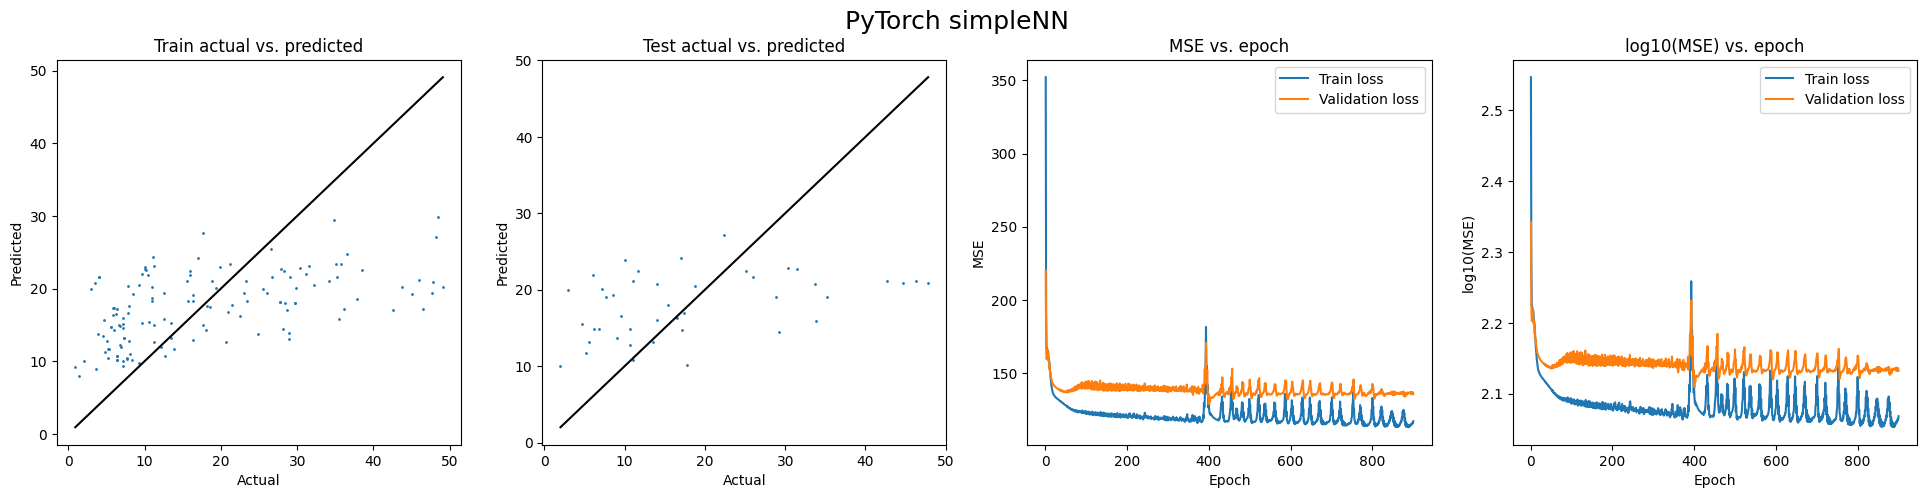

In [66]:
adaFNN_1_bn.useful_plots(dataloader)

### Examine basis functions

Inner products between all pairs of normalized basis functions:
AdaFNN 0:


<IPython.core.display.Math object>

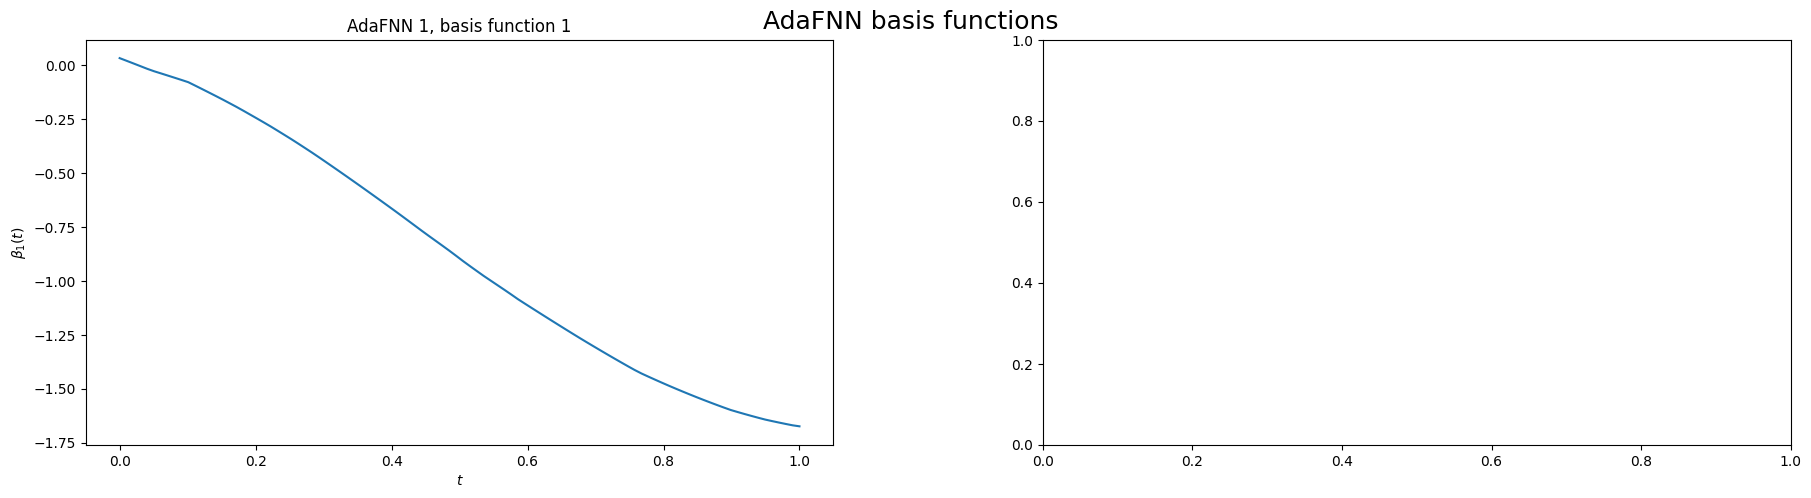

In [67]:
adafnns = [adaFNN_1_bn]

def _normalized_inner_product(f, g, h):
    f_norm = afr.math._inner_product(f, f, h)
    g_norm = afr.math._inner_product(g, g, h)

    return round(afr.math._inner_product(f / torch.sqrt(f_norm), g / torch.sqrt(g_norm), h).item(), 4)

# Plot train and test actual vs. predicted.
fig, ax = plt.subplots(1, adaFNN_1_bn.n_base+1, figsize=(22, 5))
# ax = ax.flatten()
fig.suptitle("AdaFNN basis functions", fontsize=18, y=0.98)

for i in range(len(adafnns)):
    for j in range(adafnns[0].n_base):
        k = len(adafnns)*i + j
        ax[k].plot(t, adafnns[i].bases[j].flatten())
        ax[k].set_xlabel("$t$")
        ax[k].set_ylabel(f"$\\beta_{j+1}(t)$")
        ax[k].set_title(f"AdaFNN {i+1}, basis function {j+1}")

fig.subplots_adjust(top=0.92, hspace=0.32, wspace=0.28)

print("Inner products between all pairs of normalized basis functions:")
for i in range(len(adafnns)):
    adafnn = adafnns[i]
    print(f"AdaFNN {i}:")
    for j in range(adafnn.n_base):
        for k in range(j,adafnn.n_base):
            display(Math(r"\left< \beta_{}, \beta_{} \right> = {}".format(j, k, _normalized_inner_product(adafnn.bases[j], adafnn.bases[k], adafnn.h))))

plt.show()